Using device: cpu
Train size: 54000, Val size: 6000, Test size: 10000
==> WD = 0.0
Epoch 01 | train_acc=0.6656 | val_acc=0.7960
Epoch 02 | train_acc=0.8299 | val_acc=0.8500
Epoch 03 | train_acc=0.8638 | val_acc=0.8753
Epoch 04 | train_acc=0.8800 | val_acc=0.8840
Epoch 05 | train_acc=0.8881 | val_acc=0.8873
Epoch 06 | train_acc=0.8943 | val_acc=0.8925
Epoch 07 | train_acc=0.8983 | val_acc=0.8955
Epoch 08 | train_acc=0.9016 | val_acc=0.8982
==> WD = 0.0001
Epoch 01 | train_acc=0.6403 | val_acc=0.8023
Epoch 02 | train_acc=0.8309 | val_acc=0.8498
Epoch 03 | train_acc=0.8630 | val_acc=0.8727
Epoch 04 | train_acc=0.8788 | val_acc=0.8830
Epoch 05 | train_acc=0.8884 | val_acc=0.8855
Epoch 06 | train_acc=0.8937 | val_acc=0.8930
Epoch 07 | train_acc=0.8982 | val_acc=0.8947
Epoch 08 | train_acc=0.9016 | val_acc=0.8990
==> WD = 0.0005
Epoch 01 | train_acc=0.6690 | val_acc=0.8038
Epoch 02 | train_acc=0.8364 | val_acc=0.8558
Epoch 03 | train_acc=0.8663 | val_acc=0.8758
Epoch 04 | train_acc=0.8801 | 

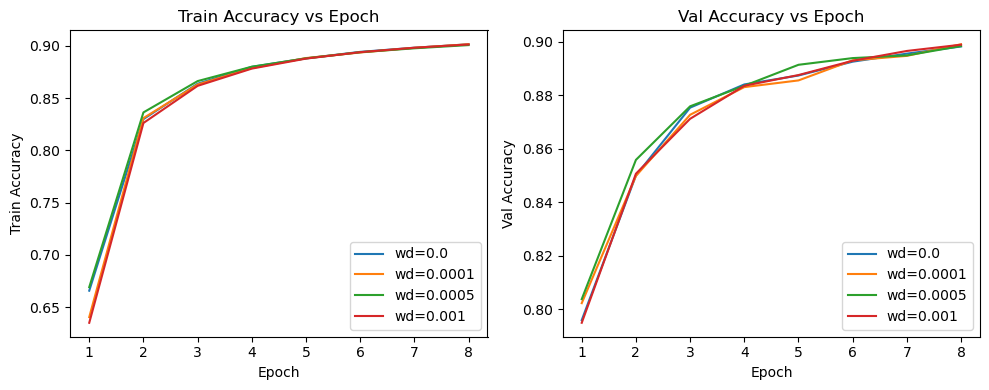

Saved figure to figs/wd_compare.png


In [1]:
# Day10: Weight Decay Comparison on MNIST (MLP)

# 📌 实验目标：
# - 对比不同 weight decay 值对 MLP 的影响
# - 数据集：MNIST
# - 模型：两层 MLP
# - 对比 wd = [0, 1e-4, 5e-4, 1e-3]
# - 输出：训练/验证准确率曲线，并保存图像

# 🔧 配置
WD_VALUES = [0.0, 1e-4, 5e-4, 1e-3]
EPOCHS = 8
BATCH_SIZE = 128
LR = 0.01
VAL_RATIO = 0.1
SEED = 42
FIG_PATH = "figs/wd_compare.png"

# 🚀 导入依赖
import os, random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 设备选择
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# 设置随机种子
torch.manual_seed(SEED)
random.seed(SEED)

# 📦 数据准备
transform = transforms.ToTensor()
train_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_set  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# 划分 train/val
val_size = int(len(train_full) * VAL_RATIO)
train_size = len(train_full) - val_size
train_set, val_set = random_split(train_full, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train size: {len(train_set)}, Val size: {len(val_set)}, Test size: {len(test_set)}")

# 🧠 模型定义：简单两层 MLP
class MLP(nn.Module):
    def __init__(self, in_dim=28*28, hidden=256, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden)
        self.fc2 = nn.Linear(hidden, num_classes)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 📊 准确率计算
def accuracy(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.numel()
    return correct / total

# 🚀 训练单个 epoch
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total, correct = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.numel()
    return correct / total  # 训练准确率

# 🎯 主实验循环
results = {wd: {"train_acc": [], "val_acc": []} for wd in WD_VALUES}

for wd in WD_VALUES:
    model = MLP().to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=wd)
    print(f"==> WD = {wd}")
    for epoch in range(1, EPOCHS + 1):
        train_acc = train_one_epoch(model, train_loader, optimizer, DEVICE)
        val_acc = accuracy(model, val_loader, DEVICE)
        results[wd]["train_acc"].append(train_acc)
        results[wd]["val_acc"].append(val_acc)
        print(f"Epoch {epoch:02d} | train_acc={train_acc:.4f} | val_acc={val_acc:.4f}")

# 📈 绘图：训练 & 验证准确率
os.makedirs(os.path.dirname(FIG_PATH), exist_ok=True)
epochs = list(range(1, EPOCHS + 1))

plt.figure(figsize=(10,4))
# 训练集
plt.subplot(1,2,1)
for wd, hist in results.items():
    plt.plot(epochs, hist["train_acc"], label=f"wd={wd}")
plt.xlabel("Epoch"); plt.ylabel("Train Accuracy"); plt.title("Train Accuracy vs Epoch"); plt.legend()

# 验证集
plt.subplot(1,2,2)
for wd, hist in results.items():
    plt.plot(epochs, hist["val_acc"], label=f"wd={wd}")
plt.xlabel("Epoch"); plt.ylabel("Val Accuracy"); plt.title("Val Accuracy vs Epoch"); plt.legend()

plt.tight_layout()
plt.savefig(FIG_PATH, dpi=150, bbox_inches="tight")
plt.show()

print(f"Saved figure to {FIG_PATH}")

# 📝 观察：
# - wd=0 → 训练准确率高，验证准确率可能低（过拟合）
# - wd 适中（如 1e-4, 5e-4）→ 验证准确率更好
# - wd 太大（1e-3）→ 训练/验证都下降（欠拟合）


版本一：纯 Weight Decay 对比
optimizer = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=wd)

实验只比较 不同的 wd 值：0, 1e-4, 5e-4, 1e-3

画训练/验证准确率 → 看 weight decay 如何影响过拟合

版本二：多方法对比（带梯度裁剪/列范数约束）
梯度裁剪
nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)

列范数约束
W = model.fc1.weight.data
norms = W.norm(2, dim=1, keepdim=True)
desired = torch.clamp(norms, max=col_norm)
model.fc1.weight.data = W * (desired / (1e-8 + norms))


除了 weight decay，还加了 两种显式约束：

梯度裁剪 (Gradient Clipping)：限制每次更新时，梯度的大小不能超过阈值。防止学习率大时爆炸。

列范数约束 (Column Norm Constraint)：强制限制权重矩阵每一列的 L2 范数 ≤ 某个上限。避免某个神经元权重过大。


==> Running No Reg (wd=0)
Epoch 1 | train=0.8529 | val=0.9053
Epoch 2 | train=0.9149 | val=0.9193
Epoch 3 | train=0.9303 | val=0.9323
Epoch 4 | train=0.9420 | val=0.9395
Epoch 5 | train=0.9497 | val=0.9462

==> Running Weight Decay (1e-4)
Epoch 1 | train=0.8510 | val=0.9032
Epoch 2 | train=0.9147 | val=0.9123
Epoch 3 | train=0.9313 | val=0.9302
Epoch 4 | train=0.9413 | val=0.9397
Epoch 5 | train=0.9485 | val=0.9442

==> Running Grad Clip (max_norm=1.0)
Epoch 1 | train=0.8537 | val=0.9028
Epoch 2 | train=0.9153 | val=0.9198
Epoch 3 | train=0.9310 | val=0.9325
Epoch 4 | train=0.9417 | val=0.9393
Epoch 5 | train=0.9497 | val=0.9448

==> Running Col Norm (≤3.0)
Epoch 1 | train=0.8488 | val=0.9008
Epoch 2 | train=0.9153 | val=0.9202
Epoch 3 | train=0.9303 | val=0.9310
Epoch 4 | train=0.9399 | val=0.9365
Epoch 5 | train=0.9481 | val=0.9450


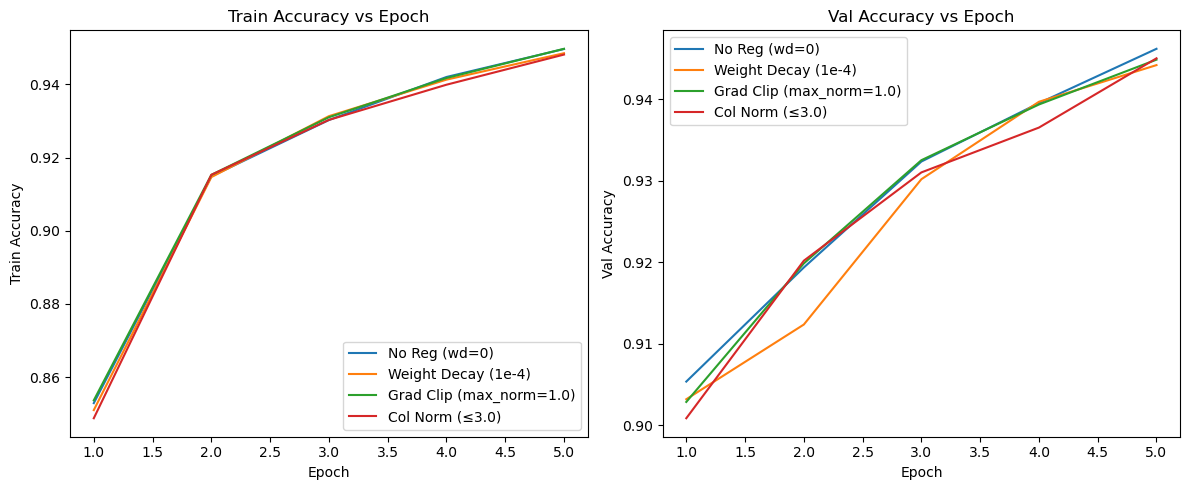

In [2]:
# 🧪 MNIST MLP 对比实验：Weight Decay vs Gradient Clipping vs Column Norm Constraint

import os, random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ======================
# 🔧 配置
# ======================
EPOCHS = 5
BATCH_SIZE = 128
LR = 0.1            # 用较高学习率，放大梯度爆炸的可能性
VAL_RATIO = 0.1
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(SEED)
random.seed(SEED)

# ======================
# 📦 数据
# ======================
transform = transforms.ToTensor()
train_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

val_size = int(len(train_full) * VAL_RATIO)
train_size = len(train_full) - val_size
train_set, val_set = random_split(train_full, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

# ======================
# 🧠 模型
# ======================
class MLP(nn.Module):
    def __init__(self, in_dim=28*28, hidden=256, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden)
        self.fc2 = nn.Linear(hidden, num_classes)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ======================
# 📊 准确率计算
# ======================
def accuracy(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.numel()
    return correct / total

# ======================
# 🚀 训练函数（可选正则化）
# ======================
def train_one_epoch(model, loader, optimizer, device,
                    grad_clip=None, col_norm=None):
    model.train()
    total, correct = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        
        # 梯度裁剪
        if grad_clip is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)
        
        optimizer.step()
        
        # 列范数约束（对 fc1 的每列限制）
        if col_norm is not None:
            with torch.no_grad():
                W = model.fc1.weight.data  # [256, 784]
                norms = W.norm(2, dim=1, keepdim=True)  # 每一行的 L2 范数
                desired = torch.clamp(norms, max=col_norm)
                model.fc1.weight.data = W * (desired / (1e-8 + norms))
        
        with torch.no_grad():
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.numel()
    return correct / total  # 返回训练集准确率

# ======================
# 🎯 主实验
# ======================
configs = {
    "No Reg (wd=0)": dict(wd=0.0, grad_clip=None, col_norm=None),
    "Weight Decay (1e-4)": dict(wd=1e-4, grad_clip=None, col_norm=None),
    "Grad Clip (max_norm=1.0)": dict(wd=0.0, grad_clip=1.0, col_norm=None),
    "Col Norm (≤3.0)": dict(wd=0.0, grad_clip=None, col_norm=3.0),
}

results = {name: {"train_acc": [], "val_acc": []} for name in configs}

for name, cfg in configs.items():
    print(f"\n==> Running {name}")
    model = MLP().to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=cfg["wd"])
    
    for epoch in range(1, EPOCHS+1):
        train_acc = train_one_epoch(
            model, train_loader, optimizer, DEVICE,
            grad_clip=cfg["grad_clip"], col_norm=cfg["col_norm"]
        )
        val_acc = accuracy(model, val_loader, DEVICE)
        results[name]["train_acc"].append(train_acc)
        results[name]["val_acc"].append(val_acc)
        print(f"Epoch {epoch} | train={train_acc:.4f} | val={val_acc:.4f}")

# ======================
# 📈 绘图（直接显示）
# ======================
epochs = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12,5))
# Train acc
plt.subplot(1,2,1)
for name, hist in results.items():
    plt.plot(epochs, hist["train_acc"], label=name)
plt.xlabel("Epoch"); plt.ylabel("Train Accuracy"); plt.title("Train Accuracy vs Epoch"); plt.legend()

# Val acc
plt.subplot(1,2,2)
for name, hist in results.items():
    plt.plot(epochs, hist["val_acc"], label=name)
plt.xlabel("Epoch"); plt.ylabel("Val Accuracy"); plt.title("Val Accuracy vs Epoch"); plt.legend()

plt.tight_layout()
plt.show()


不够平稳，提升epoch


===== Training with weight_decay=0.0 =====
Epoch 01 | train=0.8574 | val=0.9155
Epoch 02 | train=0.9182 | val=0.9314
Epoch 03 | train=0.9337 | val=0.9415
Epoch 04 | train=0.9441 | val=0.9470
Epoch 05 | train=0.9517 | val=0.9535
Epoch 06 | train=0.9576 | val=0.9565
Epoch 07 | train=0.9601 | val=0.9591
Epoch 08 | train=0.9628 | val=0.9612
Epoch 09 | train=0.9647 | val=0.9616
Epoch 10 | train=0.9665 | val=0.9641
Epoch 11 | train=0.9685 | val=0.9653
Epoch 12 | train=0.9698 | val=0.9662
Epoch 13 | train=0.9702 | val=0.9652
Epoch 14 | train=0.9707 | val=0.9671
Epoch 15 | train=0.9719 | val=0.9668

===== Training with weight_decay=0.0001 =====
Epoch 01 | train=0.8600 | val=0.9081
Epoch 02 | train=0.9181 | val=0.9300
Epoch 03 | train=0.9332 | val=0.9409
Epoch 04 | train=0.9439 | val=0.9485
Epoch 05 | train=0.9519 | val=0.9540
Epoch 06 | train=0.9578 | val=0.9569
Epoch 07 | train=0.9601 | val=0.9589
Epoch 08 | train=0.9628 | val=0.9613
Epoch 09 | train=0.9645 | val=0.9622
Epoch 10 | train=0.96

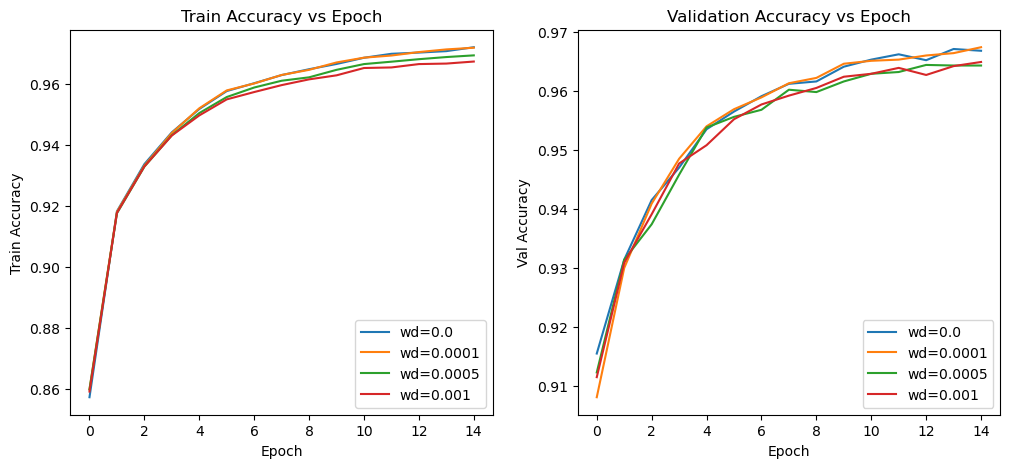

In [9]:
# =====================
# 📦 导入库
# =====================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# =====================
# 🧠 定义模型
# =====================
class MLP(nn.Module):
    def __init__(self, in_dim=28*28, hidden=256, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden)
        self.fc2 = nn.Linear(hidden, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# =====================
# 📊 准确率计算
# =====================
def accuracy(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.numel()
    return correct / total

# =====================
# 🚀 单个 epoch 训练
# =====================
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total, correct = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.numel()
    return correct / total

# =====================
# 🎯 主训练函数
# =====================
def train_model(model, train_loader, val_loader, optimizer, scheduler, device,
                max_epochs=20, patience=3):
    best_val = 0
    bad_epochs = 0
    train_acc_hist, val_acc_hist = [], []

    for epoch in range(1, max_epochs+1):
        train_acc = train_one_epoch(model, train_loader, optimizer, device)
        val_acc = accuracy(model, val_loader, device)

        scheduler.step()
        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)

        print(f"Epoch {epoch:02d} | train={train_acc:.4f} | val={val_acc:.4f}")

        # Early stopping
        if val_acc > best_val:
            best_val = val_acc
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print("⏹️ Early stopping triggered!")
                break

    return train_acc_hist, val_acc_hist

# =====================
# 📥 加载数据
# =====================
transform = transforms.Compose([transforms.ToTensor()])

train_set = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_set = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(test_set, batch_size=1000, shuffle=False)

# =====================
# ⚡ 训练不同 wd 对比
# =====================
device = "cuda" if torch.cuda.is_available() else "cpu"
results = {}

for wd in [0.0, 1e-4, 5e-4, 1e-3]:
    print(f"\n===== Training with weight_decay={wd} =====")
    model = MLP().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05, weight_decay=wd)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    train_hist, val_hist = train_model(
        model, train_loader, val_loader, optimizer, scheduler, device,
        max_epochs=15, patience=3
    )
    results[wd] = (train_hist, val_hist)

# =====================
# 📊 绘图
# =====================
plt.figure(figsize=(12, 5))

# 训练准确率
plt.subplot(1, 2, 1)
for wd, (train_hist, val_hist) in results.items():
    plt.plot(train_hist, label=f"wd={wd}")
plt.xlabel("Epoch")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Epoch")
plt.legend()

# 验证准确率
plt.subplot(1, 2, 2)
for wd, (train_hist, val_hist) in results.items():
    plt.plot(val_hist, label=f"wd={wd}")
plt.xlabel("Epoch")
plt.ylabel("Val Accuracy")
plt.title("Validation Accuracy vs Epoch")
plt.legend()

plt.show()
